**Imports**

In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans

**Translate Synthetic Data Into Peak Finding Output**

In [2]:
synth_peak1 = np.loadtxt('Three_gaussians_oneblue_onered_peak1.txt')
synth_peak2 = np.loadtxt('Three_gaussians_oneblue_onered_peak2.txt')
synth_peak3 = np.loadtxt('Three_gaussians_oneblue_onered_peak3.txt')

In [9]:
positions = np.array([[synth_peak1[i][0], synth_peak2[i][0], synth_peak3[i][0]] for i in range(5000)])
heights = np.array([[synth_peak1[i][1], synth_peak2[i][1], synth_peak3[i][1]] for i in range(5000)])
widths = np.array([[synth_peak1[i][2], synth_peak2[i][2], synth_peak3[i][2]] for i in range(5000)])

In [14]:
first_comp = np.array([[positions[i][0], heights[i][0], widths[i][0], i] for i in range(5000)])
sec_comp = np.append(first_comp, [[positions[i][1], heights[i][1], widths[i][1], i] for i in range(5000)], axis=0)
all_points = np.append(sec_comp, [[positions[i][2], heights[i][2], widths[i][2], i] for i in range(5000)], axis=0)
np.shape(all_points)

(15000, 4)

In [15]:
all_points

array([[3.500e+02, 1.000e+00, 3.000e+02, 0.000e+00],
       [3.500e+02, 9.672e-01, 3.000e+02, 1.000e+00],
       [3.500e+02, 9.355e-01, 3.000e+02, 2.000e+00],
       ...,
       [5.500e+02, 1.836e+00, 6.000e+01, 4.997e+03],
       [5.500e+02, 1.836e+00, 6.000e+01, 4.998e+03],
       [5.500e+02, 1.836e+00, 6.000e+01, 4.999e+03]])

In [16]:
all_points_df = pd.DataFrame(all_points, columns=['Position', 'Height', 'Width', 'Time'])
all_points_df.describe()

,Position,Height,Width,Time
count,15000.000000,1.500000e+04,15000.000000,15000.000000
mean,316.680000,5.462816e-01,170.000000,2499.500000
std,176.380795,6.227926e-01,98.998249,1443.423759
min,50.000000,0.000000e+00,60.000000,0.000000
25%,175.000000,7.958250e-19,60.000000,1249.750000
50%,250.000000,2.551500e-01,150.000000,2499.500000
75%,550.000000,9.663750e-01,300.000000,3749.250000
max,550.000000,1.836000e+00,300.000000,4999.000000


**Set number of clusters and train algorithm using all input data**

http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans.transform

* Number of clusters is based on number of peaks (or indexes) found by peak finder

In [18]:
cluster = KMeans(n_clusters=3).fit(all_points[:,:-1])
cluster.labels_

array([0, 0, 0, ..., 1, 1, 1])

Rough first shot at visualizing clustering

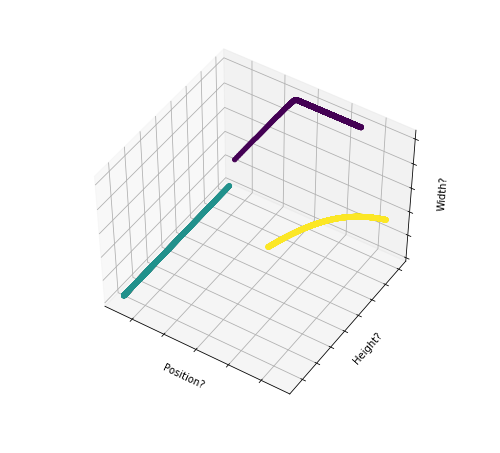

In [39]:
fignum = 1
fig = plt.figure(fignum, figsize=(7, 6))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=50, azim=123)
cluster
labels = cluster.labels_

ax.scatter(all_points[:, 0], all_points[:, 1], all_points[:, 2],
             c=labels.astype(np.float))

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
ax.set_xlabel('Position?')
ax.set_ylabel('Height?')
ax.set_zlabel('Width?')
ax.dist = 12

**Make iterative loop to test each data point against clusters**

Essentially, we take all data and scatter it on the plot.
Then, one by one, we classify the peak based on which region it is most likely to belong to.

In [19]:
peak1_list = []
peak2_list = []
peak3_list = []

for i in range(15000):
    peak = cluster.predict([all_points[i][:-1]])
    if ( peak == 0 ):
        peak1_list.append(all_points[i])
    elif ( peak == 1 ):
        peak2_list.append(all_points[i])
    elif ( peak == 2 ):
        peak3_list.append(all_points[i])
    else:
        print('all_points[i] broke it!')

**Feed lists generated by classifying peaks into DataFrames.**

We place them into DataFrames so that the data can be easily manipulated and cleaned.
* One specific bonus is dropping duplicates

In [20]:
peak1_unfilt = pd.DataFrame(peak1_list, columns=['Position', 'Height', 'Width', 'Time'])
peak1 = peak1_unfilt.drop_duplicates(subset='Time')

peak2_unfilt = pd.DataFrame(peak2_list, columns=['Position', 'Height', 'Width', 'Time'])
peak2 = peak2_unfilt.drop_duplicates(subset='Time')

peak3_unfilt = pd.DataFrame(peak3_list, columns=['Position', 'Height', 'Width', 'Time'])
peak3 = peak3_unfilt.drop_duplicates(subset='Time')

In [21]:
peak1.describe()

,Position,Height,Width,Time
count,5000.000000,5.000000e+03,5000.0,5000.000000
mean,250.020000,6.100534e-03,300.0,2499.500000
std,57.742241,5.535738e-02,0.0,1443.520003
min,150.000000,4.286000e-73,300.0,0.000000
25%,200.000000,5.298000e-55,300.0,1249.750000
50%,250.000000,6.548000e-37,300.0,2499.500000
75%,300.000000,8.092000e-19,300.0,3749.250000
max,350.000000,1.000000e+00,300.0,4999.000000


In [22]:
peak2.describe()

,Position,Height,Width,Time
count,5000.0,5000.000000,5000.0,5000.000000
mean,550.0,1.265487,60.0,2499.500000
std,0.0,0.505516,0.0,1443.520003
min,550.0,0.000000,60.0,0.000000
25%,550.0,0.929350,60.0,1249.750000
50%,550.0,1.427000,60.0,2499.500000
75%,550.0,1.693000,60.0,3749.250000
max,550.0,1.836000,60.0,4999.000000


In [24]:
peak3.describe()

,Position,Height,Width,Time
count,5000.000000,5000.000000,5000.0,5000.000000
mean,150.020000,0.367257,150.0,2499.500000
std,57.742241,0.252756,0.0,1443.520003
min,50.000000,0.082130,150.0,0.000000
25%,100.000000,0.153400,150.0,1249.750000
50%,150.000000,0.286550,150.0,2499.500000
75%,200.000000,0.535350,150.0,3749.250000
max,250.000000,1.000000,150.0,4999.000000


**Plot the results.**

A next step is having these lines fit with exponentials to compare multi-peak features.

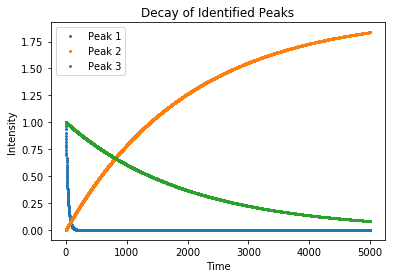

In [25]:
plt.plot(peak1['Time'], peak1['Height'], 'o', markersize = 2, label = 'Peak 1')
plt.plot(peak2['Time'], peak2['Height'], 'o', markersize = 2, label = 'Peak 2')
plt.plot(peak3['Time'], peak3['Height'], 'o', markersize = 2, label = 'Peak 3')
plt.title('Kinetics of Identified Peaks')
plt.xlabel('Time')
plt.ylabel('Intensity')
plt.legend()
plt.show()

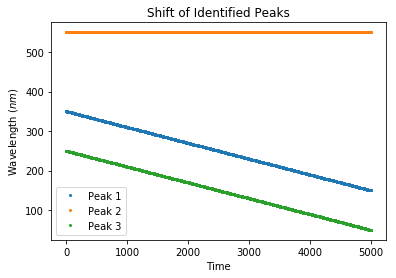

In [28]:
plt.plot(peak1['Time'], peak1['Position'], 'o', markersize = 2, label = 'Peak 1')
plt.plot(peak2['Time'], peak2['Position'], 'o', markersize = 2, label = 'Peak 2')
plt.plot(peak3['Time'], peak3['Position'], 'o', markersize = 2, label = 'Peak 3')
plt.title('Shift of Identified Peaks')
plt.xlabel('Time')
plt.ylabel('Wavelength $(nm)$')
plt.legend()
plt.show()